# Tensor factorisation

In [1]:
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
# The tthresh library is available at https://github.com/rballester/tthresh

In [98]:
# read file
original, fs = librosa.core.load("trance.wav", sr=44100, mono=False)
#original, fs = librosa.core.load("adagio.wav", sr=44100, mono=False)

# process
spectrogram = np.array([librosa.core.stft(original[0], n_fft=1024), librosa.core.stft(original[1], n_fft=1024)])
abs_spectrogram = np.abs(spectrogram)
c, m, n = abs_spectrogram.shape

## Without quantisation

In [12]:
np.save("unquantised.npy", abs_spectrogram)
c, m, n

(2, 513, 5678)

In [15]:
# Now compress and decompress with tthresh (adjust the dimensions according to c, m, n above)
# ./tthresh -i unquantised.npy -t float -s 4101 513 2 -k 128 -e 0.02  -c unquantised.ttr 
# ./tthresh -c unquantised.ttr -o unquantised.dec
# Prepend original 128 byte numpy header (in unquant_header.bin) to unquantised.dec
dec = np.load("unquantised.dec")
reconstructed_waveform = np.vstack((librosa.core.spectrum.griffinlim(dec[0]), librosa.core.spectrum.griffinlim(dec[1])))
sf.write('unquantised.wav', reconstructed_waveform.T, fs)

## With quantisation

In [84]:
# quantisation (high gamma, as 32-bit unsigned integers can handle integers up to 65535)
quantised_spectrogram = (1000 * np.sqrt(abs_spectrogram, out=np.zeros_like(abs_spectrogram), where=(abs_spectrogram != 0))).round()

In [14]:
np.save("quantised.npy", quantised_spectrogram.astype(np.int32))

In [20]:
# Note the different type in the command
# ./tthresh -i quantised.npy -t int -s 4101 513 2 -k 128 -e 0.02  -c quantised.ttr  
# ./tthresh -c quantised.ttr -o quantised.dec
# Prepend original 128 byte numpy header (in quant_header.bin) to quantised.dec
dec = np.load("quantised.dec")
# Dequantise
dec = np.square(dec/1000)
reconstructed_waveform = np.vstack((librosa.core.spectrum.griffinlim(dec[0]), librosa.core.spectrum.griffinlim(dec[1])))
sf.write('quantised.wav', reconstructed_waveform.T, fs)

## With splits at repetitions

In [102]:
# With split frames
delta_t = 550 # distance between repetitions
min_t = 150 # time of first repetition
split_spectrogram = np.zeros([c, m, n//delta_t, delta_t], dtype=np.int32)
for i0 in range(c): # channels
    rep_idx = 0
    for i1 in range(min_t, n-delta_t, delta_t): # Time slices
        split_spectrogram[i0, :, rep_idx, :] = quantised_spectrogram[i0, :, i1:i1+delta_t]
        rep_idx += 1

In [106]:
np.save("quantsplit.npy", split_spectrogram)

In [178]:
# ./tthresh -i quantsplit.npy -t int -s 550 7 513 2 -k 128 -e 0.07 -c quantsplit.ttr
# ./tthresh -c quantsplit.ttr -o quantsplit.dec
dec = np.load("quantsplit.dec")

In [179]:
dec = np.square(dec/1000)
rec_spectrogram = np.zeros([dec.shape[0], dec.shape[1], dec.shape[2] * dec.shape[3]])
delta_t = dec.shape[3]
# Reconstruct from time slices
for i0 in range(dec.shape[0]):
    for i1 in range(dec.shape[2]):
        rec_spectrogram[i0, :, i1*delta_t:(i1+1)*delta_t] = dec[i0, :, i1, :]

In [180]:
reconstructed_waveform = np.vstack((librosa.core.spectrum.griffinlim(rec_spectrogram[0]), librosa.core.spectrum.griffinlim(rec_spectrogram[1])))
sf.write('quantsplit.wav', reconstructed_waveform.T, fs)

In [ ]:
# Export for figure
for i in range(split_spectrogram.shape[2]):
    plt.matshow(np.flip(split_spectrogram[0, :150, i, :], 0))
    plt.axis('off')
    plt.savefig(f"{i}.png", dpi=200, bbox_inches='tight')

## Tensor factorisation

In [23]:
import tensorly as tl

In [33]:
core, factors = tl.decomposition.tucker(abs_spectrogram, n_iter_max=50, rank=abs_spectrogram.shape)

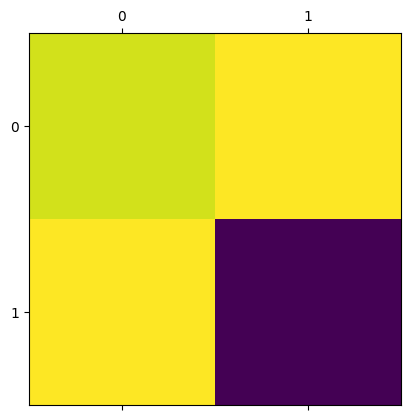

In [47]:
plt.matshow(factors[0][ 0:200, :200])

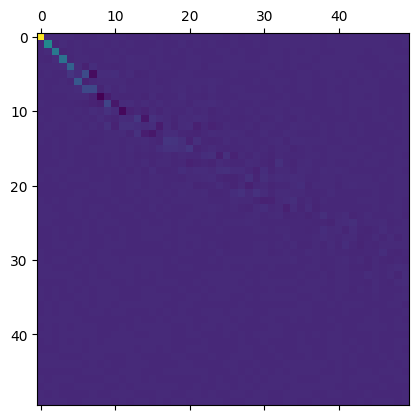

In [37]:
plt.matshow(core[0, :50, :])

## Autocorrelation

In [140]:
import scipy.signal

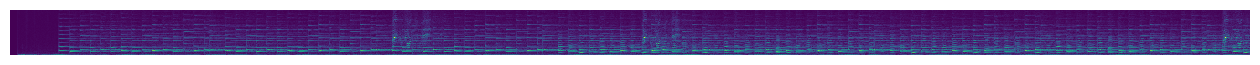

In [175]:
window = quantised_spectrogram[0, 0:150, 0:]
plt.matshow(np.flip(window, 0))

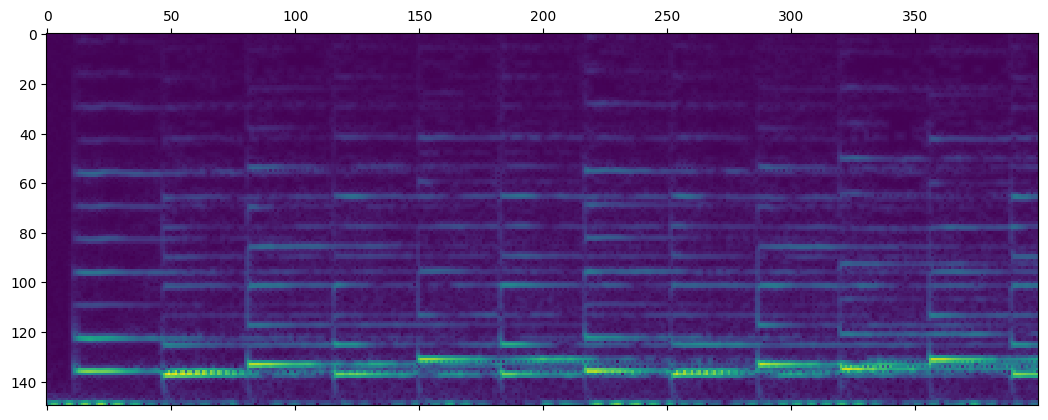

In [138]:
# Extract block (without inspection)
block = window[:, 150:550]
plt.matshow(np.flip(block, 0))

In [141]:
# Compute autocorrelation
corr = scipy.signal.correlate(window, block, mode="valid") 

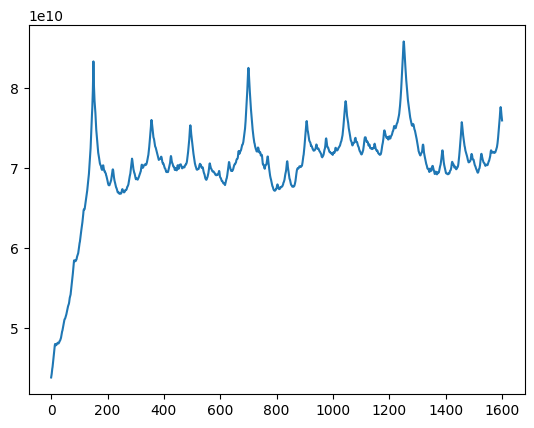

In [142]:
plt.plot(corr[0])

In [143]:
# Show instance with highest correlation
np.argmax(corr[0])

1251

In [144]:
# 150 is plausible, as this is the first occurrence of the block within the window.
# Now, examine at which frames correlation is within 5% of the global maximum
arg_rep = np.argwhere(corr[0] > (corr[0].max() * 0.95))
arg_rep

array([[ 150],
       [ 699],
       [ 700],
       [ 701],
       [1245],
       [1246],
       [1247],
       [1248],
       [1249],
       [1250],
       [1251],
       [1252],
       [1253],
       [1254],
       [1255],
       [1256],
       [1257],
       [1258]])

In [145]:
# Taking the an approximate mean distance between the local maxima, we obtain
# 700 - 150 = 1250 - 700 = 550
# thus, the pattern repeats approximately every 550 frames

In [ ]:
# For external plotting
s = ""
for i, v in enumerate(c[0]):
    s += f"{i} {v/10e5}\n"
with open("correlation_data.txt", "w") as file:
    file.write(s)
    file.close()